In [2]:
import sys
import numpy as np
import scipy as sc
import scipy.linalg as la
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (8,10)
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objects as go
from scipy.optimize import minimize_scalar, minimize, shgo, basinhopping, differential_evolution, dual_annealing
#from scipy.misc import derivative
from matplotlib import cm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import FloatProgress
from IPython.display import display, HTML
from IPython.display import Image, SVG, clear_output
#import time
%matplotlib notebook
%load_ext tikzmagic
#https://github.com/mkrphys/ipython-tikzmagic
#
#https://github.com/mkrphys/ipython-tikzmagic/issues/18
#On Ubuntu 18.04, I ran into the same issue. It seems the problem was because ImageMagick tightened 
#their security policy so that it prevented the generation of PNG file from the PDF file generated by latex. 
#To fix this problem, I edited /etc/ImageMagick-6/policy.xml, changing the following
#
#<policy domain="coder" rights="none" pattern="PDF />
#
#to
#
#<policy domain="coder" rights="read|write" pattern="PDF />
#
#http://blog.invibe.net/posts/2015-01-20-using-tikzmagic.html
#https://stackoverflow.com/questions/45671481/how-do-i-center-the-outputs-on-a-python-jupyter-notebook
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
#print(sc.__version__)
#print(numpy.__version__)

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


## Lattice and Unit Cell
1-Site Unit Cell

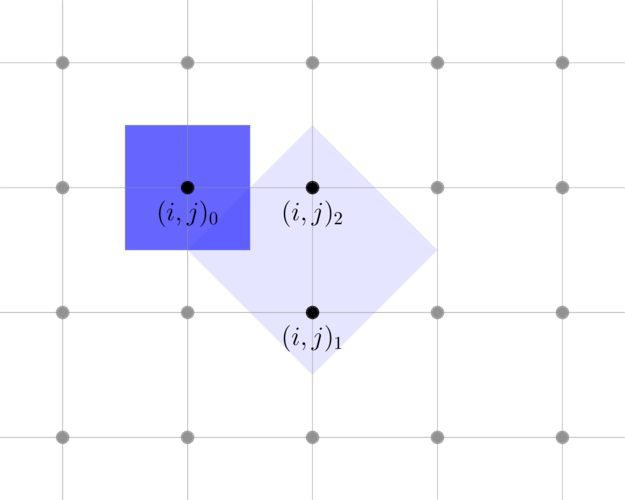

In [3]:
%%tikz -f png -s 800,500 -sc 1.2
\tikzset{>=stealth,font=\Large};

\fill [opacity=0.5,blue!20] (+4,+1) -- (+6,+3) -- (+4,+5) -- (+2,+3) -- cycle;
\fill [opacity=0.75,blue!80] (+1,+3) -- (+3,+3) -- (+3,+5) -- (+1,+5) -- cycle;

\draw [style=help lines, step=2] (-1,-1) grid (+9,+7);
 
\filldraw [color=gray]	(0,0) circle (.1);
\filldraw [color=gray]	(0,2) circle (.1);
\filldraw [color=gray]	(0,4) circle (.1);
\filldraw [color=gray]	(0,6) circle (.1);

\filldraw [color=gray]	(2,0) circle (.1);
\filldraw [color=gray]	(2,2) circle (.1);
\filldraw [color=black]	(2,4) circle (.1);
\filldraw [color=gray]	(2,6) circle (.1);

\filldraw [color=gray]	(4,0) circle (.1);
\filldraw [color=black]	(4,2) circle (.1);
\filldraw [color=black]	(4,4) circle (.1);
\filldraw [color=gray]	(4,6) circle (.1);

\filldraw [color=gray]	(6,0) circle (.1);
\filldraw [color=gray]	(6,2) circle (.1);
\filldraw [color=gray]	(6,4) circle (.1);
\filldraw [color=gray]	(6,6) circle (.1);

\filldraw [color=gray]	(8,0) circle (.1);
\filldraw [color=gray]	(8,2) circle (.1);
\filldraw [color=gray]	(8,4) circle (.1);
\filldraw [color=gray]	(8,6) circle (.1);

\draw ( 2, 3.9) node[anchor=north] {$(i,j)_{0}$};

\draw [black] ( 4, 1.9) node[anchor=north] {$(i,j)_1$};
\draw ( 4, 3.9) node[anchor=north] {$(i,j)_2$};

## Model
$$\newcommand{\OP}[1]{\hat{#1}}$$
$$\newcommand{\vectr}[1]{\boldsymbol{#1}}$$

The Hubbard model Hamiltonian for a n-site unit cell with site index $\alpha$ reads:

\begin{equation}
\OP{H} = \underbrace{\sum_{i,j}\sum_{\alpha,\beta}\sum_{\sigma} t^{\phantom{\dagger}}_{(i,\alpha),(j,\beta)} \hat{c}^{\dagger}_{i,\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{j,\beta,\sigma}}_{=: \OP{H}_0}
 + \underbrace{U \sum_{i,\alpha}\hat{n}^{\phantom{\dagger}}_{i,\alpha,\uparrow}\hat{n}^{\phantom{\dagger}}_{i,\alpha,\downarrow}}_{=: \OP{H}_\mathrm{I}}
\end{equation}

with $\hat{n}^{\phantom{\dagger}}_{i,\alpha,\sigma} =  \hat{c}^{\dagger}_{i,\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{i,\alpha,\sigma}$. The integer index set $\{i,j\}$ labels the respective cells originating from shifting the unit cell (UC) by integral multiples of the translation vectors and $\{\alpha,\alpha'\}$ the respective site index within the cell. The number of cells will be labeled $N_{\mathrm{UC}}$ and the number of basis sites $N_{\mathrm{B}}$.

In [4]:
Hubbard_U = 0.0

### Hopping


The Fourier transformation of the general hoping term $\OP{H}_0$ reads:

\begin{equation}
 \OP{H}_0 = \sum_{\vectr{k}}\sum_{\alpha,\beta}\sum_{\sigma} \hat{c}^{\dagger}_{\vectr{k},\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{\vectr{k},\beta,\sigma} \underbrace{\left( \sum_{\vectr{\eta}_j} t^{\phantom{\dagger}}_{\alpha,\beta} e^{i\vectr{k}\cdot\vectr{\eta}_j} \right)}_{=: t_{\alpha,\beta}(\vectr{k})}.
\end{equation}

with

\begin{equation}
t_{\alpha,\beta}(\vectr{k}) = \sum_{\vectr{\eta}_j} t^{\alpha,\beta}_{\vectr{\eta}_j} e^{i\vectr{k}\cdot\vectr{\eta}_j}
\end{equation}

In [5]:
def Hopping_UC_1S(k):
        t = -1.0
        Translations = np.array([[1.0,0.0],[-1.0,0.0],[0.0,1.0],[0.0,-1.0]])
        hopping_amplitude = 0.0+0.0j
        for Tvec in Translations:
            hopping_amplitude += t*np.exp(1j*(Tvec[0]*k[0]+Tvec[1]*k[1]))
        
        return hopping_amplitude

### The Trial Hamiltonian

\begin{equation}
\begin{split}
\OP{H}^{\mathrm{HF}} 
= \sum_{\vectr{k}}\sum_{\alpha,\alpha'}
&\left(\hat{c}^{\dagger}_{\vectr{k},\alpha,\uparrow} 
\mathcal{H}^{\uparrow\uparrow}_{\alpha,\alpha'} \left(\vectr{k}\right)\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k},\alpha',\uparrow}
%
+\hat{c}^{\dagger}_{\vectr{k},\alpha,\uparrow} 
\mathcal{H}^{\uparrow\downarrow}_{\alpha,\alpha'}\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k} + \vectr{q},\alpha',\downarrow}\right.\\
%
+&\left.\hat{c}^{\dagger}_{\vectr{k}+\vectr{q},\alpha,\downarrow} 
\mathcal{H}^{\downarrow\uparrow}_{\alpha,\alpha'}\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k},\alpha',\uparrow}
%
+\hat{c}^{\dagger}_{\vectr{k}+\vectr{q},\alpha,\downarrow}
\mathcal{H}^{\downarrow\downarrow}_{\alpha,\alpha'} \left(\vectr{k}+\vectr{q}\right)\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k} + \vectr{q},\alpha',\downarrow}\right)
%
\end{split}
\end{equation}

with the matrix elements for spin and charge decoupling read:

\begin{align}
\mathcal{H}^{\uparrow\uparrow}_{\alpha,\alpha'} \left(\vectr{k}\right) &= 
t_{\alpha,\alpha'}\left(\vectr{k}\right)
+ \delta_{\alpha,\alpha'}\left[\frac{U}{2}\left( \varrho^{\phantom{\dagger}}_{\alpha} - m_{\alpha} \cos{(\theta_{\alpha})} \right) \right]\\
%
\mathcal{H}^{\uparrow\downarrow}_{\alpha,\alpha'} = \mathcal{H}^{\downarrow\uparrow}_{\alpha,\alpha'} &=
\delta_{\alpha,\alpha'} \left[ -\frac{U m_{\alpha}}{2}\sin{(\theta_{\alpha})}\right]\\
%
\mathcal{H}^{\downarrow\downarrow}_{\alpha,\alpha'} \left(\vectr{k}+\vectr{q}\right) &= 
t_{\alpha,\alpha'}\left(\vectr{k}+\vectr{q}\right)
+ \delta_{\alpha,\alpha'}\left[\frac{U}{2}\left( \varrho^{\phantom{\dagger}}_{\alpha} + m_{\alpha} \cos{(\theta_{\alpha})} \right) \right]
\end{align}

Indexing Matrix elements

\begin{equation}
 a = 2(\alpha - 1) + \sigma
\end{equation}

with spin index $\sigma\in\{0 (\uparrow),1 (\downarrow)\}$ and site index $\alpha\in\{1,2,\dots,N_B\}$

In [6]:
def Hamiltonian_UC_1S(k,q,n,m,theta):
    """"Returns np.array like Matrix"""
    
    A = np.zeros((2, 2), dtype=complex)
    
    A[0][0] = Hopping_UC_1S(k)
    A[0][0] += 0.5*Hubbard_U*n-0.5*Hubbard_U*m*np.cos(theta) + 0j
        
    A[0][1] = -0.5*Hubbard_U*m*np.sin(theta) + 0j
    
    A[1][0] = -0.5*Hubbard_U*m*np.sin(theta) + 0j
    
    A[1][1] = Hopping_UC_1S(k+q)
    A[1][1] += 0.5*Hubbard_U*n+0j+0.5*Hubbard_U*m*np.cos(theta) + 0j
    
    return A

In [7]:
Hamiltonian_UC_1S(np.array([0.0,0.0]),np.array([0.0,0.0]),0.0,0.0,0.0)

array([[-4.+0.j,  0.+0.j],
       [ 0.+0.j, -4.+0.j]])

In [8]:
number_of_steps = 100
kx_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)
ky_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)
#print(np.fabs(kx_grid[0] - kx_grid[1]))
#print(2.0*np.pi/4.0)

In [9]:
def Set_Spectrum_Bands_UC_1S(q,n,m,theta):
    Band_1 = np.zeros((1,number_of_steps))
    tempBand_1 = np.zeros(number_of_steps)

    Band_2 = np.zeros((1,number_of_steps))
    tempBand_2 = np.zeros(number_of_steps)
     
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S(np.array([kx,ky]),q,n,m,theta))
            tempBand_1[idx] = w[0]
            tempBand_2[idx] = w[1]
        Band_1 = np.concatenate((Band_1,[tempBand_1]), axis=0)
        Band_2 = np.concatenate((Band_2,[tempBand_2]), axis=0)
    
    Band_1 = np.delete(Band_1, 0, 0)
    Band_2 = np.delete(Band_2, 0, 0)
    return Band_1, Band_2

def get_Bands_UC_1S(k,q,n,m,theta):
    w, v = la.eigh(Hamiltonian_UC_1S(k,q,n,m,theta))
    return w

def Set_Spectrum_Band_i_UC_1S(i,q,n,m,theta):
    Band = np.zeros((1,number_of_steps))
    tempBand = np.zeros(number_of_steps)
    
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S(np.array([kx,ky]),q,n,m,theta))
            tempBand[idx] = w[i]
        Band = np.concatenate((Band,[tempBand]), axis=0)
    
    Band = np.delete(Band, 0, 0)

    return Band_1

In [10]:
Hubbard_U = 0.0
Band_1, Band_2 = Set_Spectrum_Bands_UC_1S(np.array([0.0,.0]),0.0,0.0,0.0)

<IPython.core.display.Javascript object>


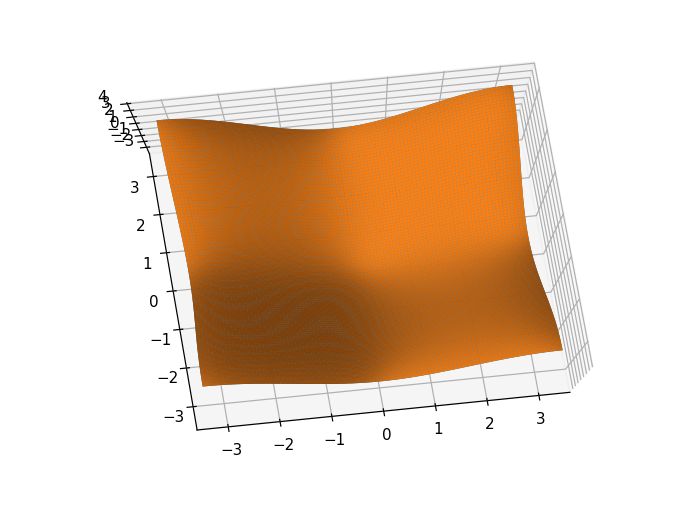

In [11]:
fig_bandstructure = plt.figure()
ax1 = Axes3D(fig_bandstructure)
kx, ky = np.meshgrid(kx_grid, ky_grid)
surf = ax1.plot_surface(kx, ky, Band_1, rstride=1, cstride=1)
surf = ax1.plot_surface(kx, ky, Band_2, rstride=1, cstride=1)
plt.show()

# Tetrahedron Method Implementation

## Goal

Support Temperature Independent Numerical Integration over 1. BZ and DOS calculation

### GZ Integration $(T=0)$ 

**Input:** n-dimension Bandstructure array for a particular band, e.g.:
- 1-D: np.array([x1, x2, ..])
- 2-D: np.array([[x11, x12, ..], [x21, x22, ..] ])
- 3-D: np.array([[[x111, x112, ..], [x121, x22, ..]], [[x212, x212, ..], [x221, x222, ..]]])

Number of steps in kx, ky, kz direction

**Algorithm:**

Sorting order ky, ky, kz

**Output:** n-dimensional array of integration weights with weights at the same position, e.g.
- 1-D: np.array([w1, w2, ..])
- 2-D: np.array([[w11, w12, ..], [w21, w22, ..] ])
- 3-D: np.array([[[w111, w112, ..], [w121, w22, ..]], [[w212, w212, ..], [w221, w222, ..]]])


### GZ Integration $(T\neq 0)$ 

**Input:** same as GZ Integration ($T=0$)

**Output:** same as GZ Integration ($T\neq0$)

### GZ DOS $(T=0)$ 

**Input:**

**Output:**

### GZ DOS $(T\neq 0)$ 

**Input:**

**Output:**

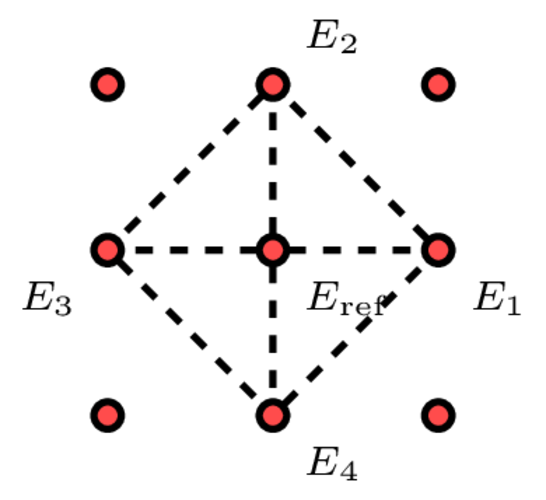

In [12]:
%%tikz -f png -s 800,500 -sc 1.0
\tikzset{>=stealth,font=\scriptsize,Node/.style = {draw, color=black, very thick, fill=red!70}};

\node (node5) at (0.0,0.0) [circle, Node, scale=0.5] {}; 
\node (node4) at (1.0,0.0) [circle, Node, scale=0.5, label=south east:$E_4$] {};
\node (node6) at (2.0,0.0) [circle, Node, scale=0.5] {};

\node (node3) at (0.0,1.0) [circle, Node, scale=0.5, label=south west:$E_3$] {};
\node (noderef) at (1.0,1.0) [circle, Node, scale=0.5, label=south east:$E_{\mathrm{ref}}$] {};
\node (node1) at (2.0,1.0) [circle, Node, scale=0.5, label=south east:$E_1$] {};

\node (node7) at (0.0,2.0) [circle, Node, scale=0.5] {}; 
\node (node2) at (1.0,2.0) [circle, Node, scale=0.5, label=north east:$E_2$] {};
\node (node8) at (2.0,2.0) [circle, Node, scale=0.5] {};

\draw [color=black, very thick, dashed] (noderef) -- (node1);
\draw [color=black, very thick, dashed] (noderef) -- (node2);
\draw [color=black, very thick, dashed] (noderef) -- (node3);
\draw [color=black, very thick, dashed] (noderef) -- (node4);

\draw [color=black, very thick, dashed] (node1) -- (node2);
\draw [color=black, very thick, dashed] (node2) -- (node3);
\draw [color=black, very thick, dashed] (node3) -- (node4);
\draw [color=black, very thick, dashed] (node4) -- (node1);


In [13]:
def sort_n_track_ref_energy_2D( e_sort_A, e_sort_B, e_sort_C):
  # A, B, C
  if e_sort_A <= e_sort_B and e_sort_B <= e_sort_C:
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 1, e_sort_A, e_sort_B, e_sort_C

# A, C, B
  if e_sort_A <= e_sort_B and e_sort_A <= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 1, e_sort_A, e_sort_B, e_sort_C

# B, A, C
  if e_sort_A >= e_sort_B and e_sort_A <= e_sort_C and e_sort_B <= e_sort_C:
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 2, e_sort_A, e_sort_B, e_sort_C

# B, C, A
  if e_sort_A >= e_sort_B and e_sort_A >= e_sort_C and e_sort_B <= e_sort_C:
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 3, e_sort_A, e_sort_B, e_sort_C

# C, A, B
  if e_sort_A <= e_sort_B and e_sort_A >= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 2, e_sort_A, e_sort_B, e_sort_C

# C, B, A
  if e_sort_A >= e_sort_B and e_sort_A >= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_A, e_sort_C)
    e_sort_A, e_sort_C = e_sort_C, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 3, e_sort_A, e_sort_B, e_sort_C

  return -1

def tetrahedron_case_2_e_ref_position_1(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*3.0*D_E_A*D_E_A*D_B_A*D_C_A\
            - Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A*D_C_A\
            - Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A*D_B_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_B_A*D_C_A*D_C_A))

def tetrahedron_case_2_e_ref_position_2(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_B_A*D_C_A))

def tetrahedron_case_2_e_ref_position_3(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_C_A*D_C_A))

def tetrahedron_case_3_e_ref_position_1(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_C_A*D_C_A*D_C_B\
            - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E)/ (3.0*Vol_full_BZ_2D*D_C_A*D_C_A*D_C_B))

def tetrahedron_case_3_e_ref_position_2(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    #print("tetrahedron_case_3_e_ref_position_2")
    #print("D_C_A", D_C_A)
    #print("D_C_B", D_C_B)
    return((Vol_Tetrahedron_2D*D_C_B*D_C_B*D_C_A\
            - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E) / (3.0*Vol_full_BZ_2D*D_C_A*D_C_B*D_C_B))

def tetrahedron_case_3_e_ref_position_3(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return(( Vol_Tetrahedron_2D*3.0*D_C_A*D_C_A*D_C_B*D_C_B - Vol_Tetrahedron_2D*D_C_E*D_C_A*D_C_B*D_C_B\
            - Vol_Tetrahedron_2D*D_C_E*D_C_B*D_C_A*D_C_A - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_A*D_C_B\
            + Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E*D_C_B + Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E*D_C_A)\
            / (3.0*Vol_full_BZ_2D*D_C_A*D_C_A*D_C_B*D_C_B))

def integration_weight_switcher(tetrahedron_case, e_ref_position,\
                                D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case = {
        1: tetrahedron_case_1,
        2: tetrahedron_case_2,
        3: tetrahedron_case_3,
        4: tetrahedron_case_4
    }
    # Get the function from switcher dictionary
    e_ref_position_switcher = switcher_tetrahedron_case.get(tetrahedron_case, lambda: "Invalid Number")
    # Execute the function
    return e_ref_position_switcher(e_ref_position,\
                                   D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                   Vol_Tetrahedron_2D, Vol_full_BZ_2D)

#Zero Contribution
def tetrahedron_case_1(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return (0.0)

def tetrahedron_case_2(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case_2_e_ref_position = {
        1: tetrahedron_case_2_e_ref_position_1,
        2: tetrahedron_case_2_e_ref_position_2,
        3: tetrahedron_case_2_e_ref_position_3
    }
    # Get the function from switcher dictionary
    integration_weigth = switcher_tetrahedron_case_2_e_ref_position.get(e_ref_position, lambda: "Invalid Number")
    # Execute the function
    return integration_weigth(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                              Vol_Tetrahedron_2D, Vol_full_BZ_2D)

def tetrahedron_case_3(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case_3_e_ref_position = {
        1: tetrahedron_case_3_e_ref_position_1,
        2: tetrahedron_case_3_e_ref_position_2,
        3: tetrahedron_case_3_e_ref_position_3
    }
    # Get the function from switcher dictionary
    integration_weigth = switcher_tetrahedron_case_3_e_ref_position.get(e_ref_position, lambda: "Invalid Number")
    # Execute the function
    return integration_weigth(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                              Vol_Tetrahedron_2D, Vol_full_BZ_2D)

#Full Contribution
def tetrahedron_case_4(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return (Vol_Tetrahedron_2D / (3.0*Vol_full_BZ_2D))

In [14]:
def Integration_weigth_2D(Chemical_Potential, E_ref_in, E_B_in, E_C_in, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    #sort e_sort_A, e_sort_B, e_sort_C, so that e_sort_A <= e_sort_B <= e_sort_C
    #http://stackoverflow.com/questions/6145364/sort-4-number-with-few-comparisons
    
    integrationweight = 0.0
    e_ref_position_tracker = -1
    tetrahedron_case_switch = -1

    e_ref_position_tracker, E_ref, E_B, E_C = sort_n_track_ref_energy_2D(E_ref_in, E_B_in, E_C_in)
    
    #print("Integration_weigth_2D", E_ref, E_B, E_C, "\n")
        
    if Chemical_Potential < E_ref:
        tetrahedron_case_switch = 1
    if E_ref <= Chemical_Potential and Chemical_Potential <= E_B:  
        tetrahedron_case_switch = 2
    if E_B < Chemical_Potential and Chemical_Potential <= E_C:
        tetrahedron_case_switch = 3
    if E_C < Chemical_Potential:
        tetrahedron_case_switch = 4

    D_E_A = Chemical_Potential - E_ref
    D_B_A = E_B - E_ref
    D_C_A = E_C - E_ref
    D_C_E = E_C - Chemical_Potential
    D_C_B = E_C - E_B

    if (np.fabs(D_B_A) <= 1e-8 or np.fabs(D_C_A) <= 1e-8 or np.fabs(D_C_B) <= 1e-8) and np.fabs(D_E_A) <= 1e-8:
        integrationweight = 0.0
    elif (np.fabs(D_B_A) <= 1e-8 or np.fabs(D_C_A) <= 1e-8 or np.fabs(D_C_B) <= 1e-8) and np.fabs(D_C_E) <= 1e-8:
        integrationweight = Vol_Tetrahedron_2D / (3.0*Vol_full_BZ_2D)
    else:
        integrationweight = integration_weight_switcher(tetrahedron_case_switch, e_ref_position_tracker,\
                                                        D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                                        Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    return(integrationweight*3.0/2.0)

In [33]:
def GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_array):
    
    Vol_full_BZ_2D = 4.0*np.pi*np.pi
    Vol_Tetrahedron_2D = 2.0*np.pi*np.pi/((number_of_steps-1)*(number_of_steps-1))
    
    integration_weigths_arr = np.zeros(shape=Band_array.shape)

    #bulk_kx_grid = np.delete(kx_grid,0,0)
    bulk_kx_grid = np.delete(kx_grid,[0,number_of_steps-1],0)
    #bulk_ky_grid = np.delete(ky_grid,0,0)
    bulk_ky_grid = np.delete(ky_grid,[0,number_of_steps-1],0)
    
    #Bulk
    for iky,ky in enumerate(bulk_ky_grid):
        for ikx,kx in enumerate(bulk_kx_grid):
            E_ref = Band_array[iky+1][ikx+1]
            E_1 = Band_array[iky+1][ikx+2]
            E_2 = Band_array[iky+2][ikx+1]
            E_3 = Band_array[iky+1][ikx]
            E_4 = Band_array[iky][ikx+1]

            #Tetrahedron 1
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_1, E_2,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)

            #Tetrahedron 2
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_2, E_3,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)

            #Tetrahedron 3
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_3, E_4,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)
                
            #Tetrahedron 4
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_4, E_1,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    
    #ky = -np.pi line
    iky = 0
    for ikx, kx in enumerate(bulk_kx_grid):
        E_ref = Band_array[iky][ikx+1]
        E_1 = Band_array[iky][ikx+2]
        E_2 = Band_array[iky+1][ikx+1]
        E_3 = Band_array[iky][ikx]
        E_4 = Band_array[iky+number_of_steps-1][ikx+1]

        #Tetrahedron 1
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_1, E_2,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 2
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_2, E_3,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 3
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_3, E_4,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 4
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_4, E_1,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #kx = -np.pi line
    ikx = 0
    for iky, ky in enumerate(bulk_ky_grid):
        E_ref = Band_array[iky+1][ikx]
        E_1 = Band_array[iky+1][ikx+1]
        E_2 = Band_array[iky+2][ikx]
        E_3 = Band_array[iky+1][ikx+number_of_steps-1]
        E_4 = Band_array[iky][ikx]

        #Tetrahedron 1
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_1, E_2,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 2
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_2, E_3,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 3
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_3, E_4,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 4
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_4, E_1,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    ## Corners
    
    #ikx = 0
    #kx = -np.pi
    #iky = 0
    #ky = -np.pi
    E_ref = Band_array[0][0]
    E_1 = Band_array[0][1]
    E_2 = Band_array[1][0]
    E_3 = Band_array[0][number_of_steps-1]
    E_4 = Band_array[number_of_steps-1][0]

    #Tetrahedron 1
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_1, E_2,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 2
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_2, E_3,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 3
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_3, E_4,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 4
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_4, E_1,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    
    return integration_weigths_arr

In [34]:
number_of_steps = 30
kx_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)
ky_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)

In [35]:
Hubbard_U = 10.0
#Set_Spectrum_Bands_UC_1S(q,n,m,theta):
Band_1, Band_2 = Set_Spectrum_Bands_UC_1S(np.array([0.1,0.0]),1.00,1.00,0.5*np.pi)

In [36]:
Chemical_Potential = -3.0
intw_arr_1 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_1)
intw_arr_2 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_2)
#print(intw_arr)

<IPython.core.display.Javascript object>


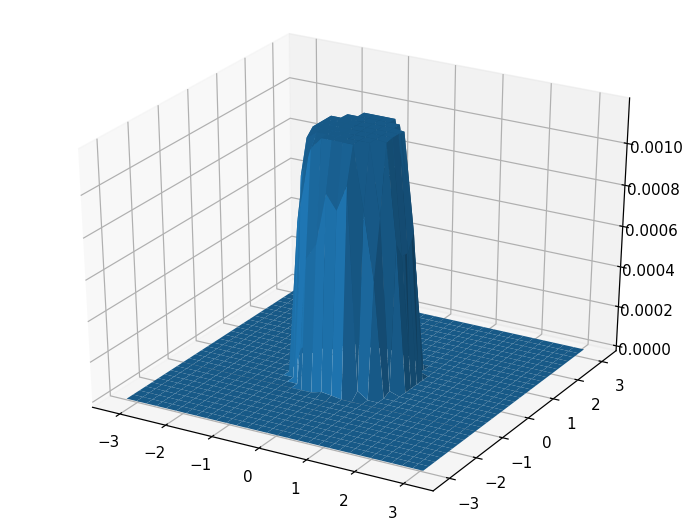

In [37]:
kx, ky = np.meshgrid(kx_grid, ky_grid)
fig_iw_arr = plt.figure()
ax1 = Axes3D(fig_iw_arr)
surf = ax1.plot_surface(kx, ky, intw_arr_1)
plt.show()

<IPython.core.display.Javascript object>


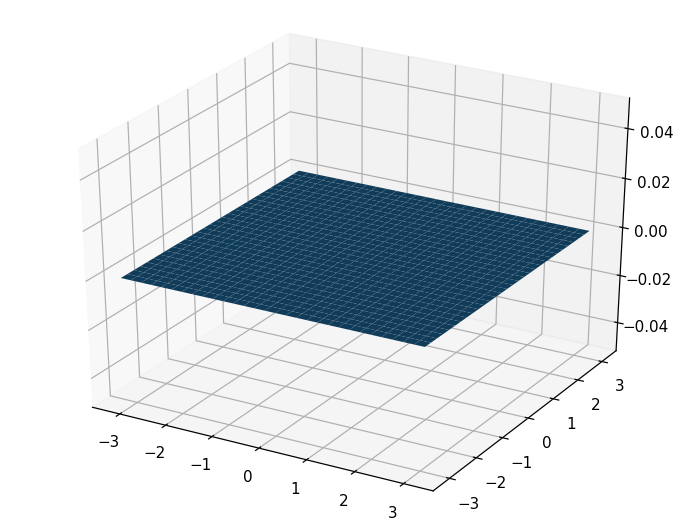

In [20]:
fig_iw_arr = plt.figure()
ax1 = Axes3D(fig_iw_arr)
surf = ax1.plot_surface(kx, ky, intw_arr_2)
plt.show()

In [38]:
Chemical_Potential = 0.0
intw_arr_1 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_1)
intw_arr_2 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_2)

#bulk_kx_grid = np.delete(kx_grid,0,0)
sum_kx_grid = np.delete(kx_grid,0,0)
#bulk_ky_grid = np.delete(ky_grid,0,0)
sum_ky_grid = np.delete(ky_grid,0,0)

sum = 0.0

#Bulk
for iky,ky in enumerate(sum_ky_grid):
    for ikx,kx in enumerate(sum_kx_grid):
        sum += intw_arr_1[iky][ikx]
        sum += intw_arr_2[iky][ikx]

print(sum)

0.5244133754284499


In [39]:
number_of_steps = 30
kx_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)
ky_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)

In [40]:
Hubbard_U = 0.0
#Set_Spectrum_Bands_UC_1S(q,n,m,theta):
Band_1, Band_2 = Set_Spectrum_Bands_UC_1S(np.array([0.0,0.0]),0.0,0.0,0.0)

<IPython.core.display.Javascript object>


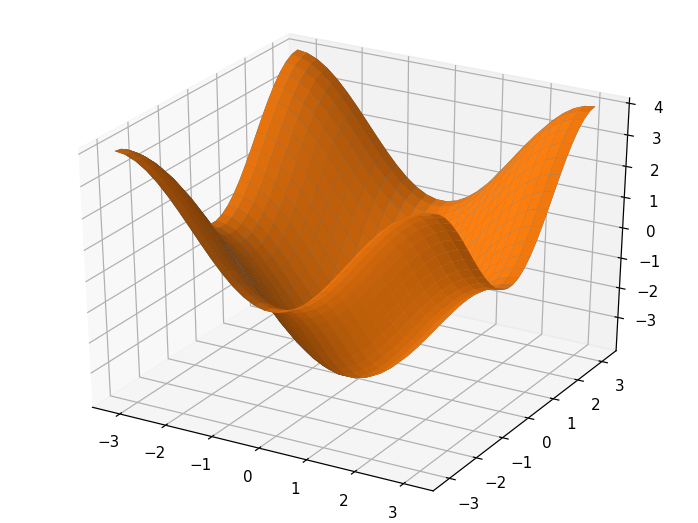

In [41]:
fig_bandstructure = plt.figure()
ax1 = Axes3D(fig_bandstructure)
kx, ky = np.meshgrid(kx_grid, ky_grid)
surf = ax1.plot_surface(kx, ky, Band_1, rstride=1, cstride=1)
surf = ax1.plot_surface(kx, ky, Band_2, rstride=1, cstride=1)
plt.show()

In [42]:
Chemical_Potential = 5.0
intw_arr_1 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_1)
intw_arr_2 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_2)

#bulk_kx_grid = np.delete(kx_grid,0,0)
sum_kx_grid = np.delete(kx_grid,0,0)
#bulk_ky_grid = np.delete(ky_grid,0,0)
sum_ky_grid = np.delete(ky_grid,0,0)

sum = 0.0

#Bulk
for iky,ky in enumerate(sum_ky_grid):
    for ikx,kx in enumerate(sum_kx_grid):
        sum += intw_arr_1[iky][ikx]
        sum += intw_arr_2[iky][ikx]

print(sum)

2.0000000000000493


<IPython.core.display.Javascript object>


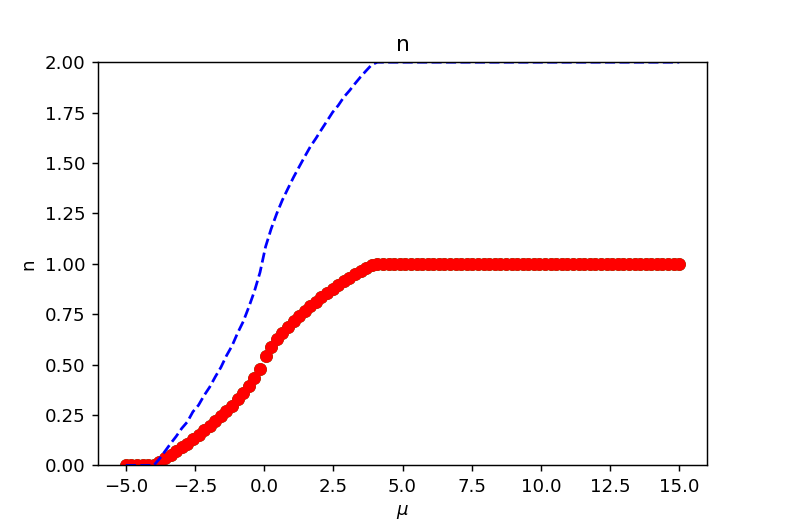

FloatProgress(value=0.0)

In [43]:
chem_pot_number_of_steps = 100
chem_pot_start = -5.0
chem_pot_end = 15.0
chem_pot_arr = np.linspace(chem_pot_start, chem_pot_end, chem_pot_number_of_steps, endpoint=True)

n_arr_1 = np.zeros(chem_pot_number_of_steps)
n_arr_2 = np.zeros(chem_pot_number_of_steps)
n_arr_total = np.zeros(chem_pot_number_of_steps)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=120)

# Plot
ax.set_title('n')
ax.set_ylabel('n')
ax.set_xlabel('$\mu$')
ax.plot(chem_pot_arr, n_arr_1, 'g+', label='n1')
ax.plot(chem_pot_arr, n_arr_2, 'ro', label='n2')
ax.plot(chem_pot_arr, n_arr_total, 'b--', label='ntotal')
ax.set_xlim(chem_pot_start,chem_pot_end)
ax.set_ylim(0.0,2.0)

plt.ion()

fig.show()
fig.canvas.draw()

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

sum_kx_grid = np.delete(kx_grid,0,0)
sum_ky_grid = np.delete(ky_grid,0,0)


for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
    
    intw_arr_1 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_1)
    intw_arr_2 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_2)

    sum_1 = 0.0
    sum_2 = 0.0
    
    for iky,ky in enumerate(sum_ky_grid):
        for ikx,kx in enumerate(sum_kx_grid):
            sum_1 += intw_arr_1[iky][ikx]
            sum_2 += intw_arr_2[iky][ikx]
    
    n_arr_1[idchem_pot] = sum_1
    n_arr_2[idchem_pot] = sum_2
    n_arr_total[idchem_pot] = sum_1 + sum_2
    
    chempotbar.value += 1
    
    ax.clear()
    ax.set_title('n')
    ax.set_ylabel('n')
    ax.set_xlabel('$\mu$')
    ax.set_ylim(0.0,2.0)
    ax.plot(chem_pot_arr, n_arr_1, 'go', label='n1')
    ax.plot(chem_pot_arr, n_arr_2, 'ro', label='n2')
    ax.plot(chem_pot_arr, n_arr_total, 'b--', label='ntotal')
    
    fig.canvas.draw()